In [1]:

## Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
from dataLoader import getDataset
from torchsummary import summary

torch.manual_seed(43)  # for reproducibility


------------------ [WindowsPath('../data/simulations/sim__saved_InputSpikes_DVTs__1000_outSpikes__128_simulationRuns__6_secDuration__randomSeed_3006033.p')]


In [2]:

train_data = getDataset()
test_data = getDataset()


Currently parsing file: sim__saved_InputSpikes_DVTs__1000_outSpikes__128_simulationRuns__6_secDuration__randomSeed_3006033.p
(1, 1278, 768000)
Done, time elapsed: 15.524 

(1, 1278, 768000)
Currently parsing file: sim__saved_InputSpikes_DVTs__1000_outSpikes__128_simulationRuns__6_secDuration__randomSeed_3006033.p
(1, 1278, 768000)
Done, time elapsed: 23.721 

(1, 1278, 768000)


In [3]:
print(train_data[100])

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], dtype=torch.float64), tensor(-78.6250, dtype=torch.float64))


In [5]:

## Helper Functions
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

BATCH_SIZE = 64
train_dl = DataLoader(train_data, BATCH_SIZE, num_workers=0)
test_dl = DataLoader(test_data, BATCH_SIZE, num_workers=4)


device = get_default_device()
print(device)

train_loader = DeviceDataLoader(train_dl, device)
val_loader = DeviceDataLoader(test_dl, device)


cuda


In [8]:
for batch in train_dl:
    print(batch)

[tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]], dtype=torch.float64), tensor([-76.9375], dtype=torch.float64)]


In [12]:
mse_loss = nn.MSELoss()

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


class BaseModule(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)
        loss = mse_loss(out, labels) 
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)  
        print(out.shape)
        print(labels.shape)
        loss = mse_loss(out, labels)   
        acc = accuracy(out, labels)        
        return {'val_loss': loss.detach(), 'val_acc': acc}
    
    def train_val_step(self, batch):
        images, labels = batch
        out = self(images)      
        loss = mse_loss(out, labels)
        acc = accuracy(out, labels)        
        return {'train_loss': loss.detach(), 'train_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
       
    def epoch_end(self, epoch, result):
        print("Epoch {}, Validation Loss: {:.4f}, Validation Accuracy: {:.4f}".format(epoch + 1, result['val_loss'], result['val_acc']))
        

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []

    if opt_func == torch.optim.SGD:
        optimizer = opt_func(model.parameters(), lr, momentum=0.9)
    else:
        optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history


def plotResults(history,name):
    losses = [entry['val_loss'] for entry in history]
    accuracy = [entry["val_acc"] for entry in history]
    train_loss = [entry["train_loss"] for entry in history]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    fig.suptitle('Model Results')

    ax1.plot(losses, '-o', label="Validation Loss")
    ax1.plot(train_loss, "-s", label="Training Loss")
    ax1.legend()
    ax1.set_ylim([0,5])
    ax1.set(xlabel = 'Epoch', ylabel="Loss")

    
    ax2.set(xlabel = 'Epoch', ylabel="Values")
    ax2.plot(accuracy, "-r")

    # plt.legend()
    ax1.set_title('Loss vs. Number of Epochs');
    ax2.set_title("Top 1% Accuracy on Validation Set");
    plt.savefig("{}-results.png".format(name))
    plt.show()

    
histories = []

In [13]:
class SimpleNet(BaseModule):
    def __init__(self):
        super(SimpleNet, self).__init__()

        self.net = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2, 2), # output: 32 x 639 x 250
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2, 2), # output: 32 x 320 x 125
    
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2, 2), # output: 32 x 160 x 63
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2, 2), # output: 64 x 80 x 32
    
            nn.Flatten(), 
            nn.Linear(45504, 256),
            nn.Tanh(),
            nn.Linear(256, 1),
        )
    def forward(self, xb):
        xb = xb.float()
        res = self.net(xb)
        return res.to(dtype=torch.float64)

# input_shape = (3,1278,500)
# summary(SimpleNet(), input_shape)


cuda
torch.Size([1, 1])
torch.Size([1])
torch.Size([1, 1])
torch.Size([1])
Epoch 1, Validation Loss: 4666.1703, Validation Accuracy: 0.0000
torch.Size([1, 1])
torch.Size([1])
Epoch 2, Validation Loss: 2684.9415, Validation Accuracy: 0.0000
torch.Size([1, 1])
torch.Size([1])
Epoch 3, Validation Loss: 2854.5619, Validation Accuracy: 0.0000


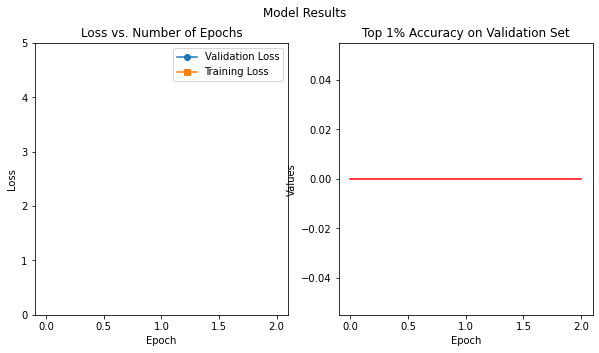

In [14]:
CUDA_LAUNCH_BLOCKING=1
print(device)
model = to_device(SimpleNet(), device)
mode = model.to(device)
history = [evaluate(model, val_loader)]
num_epochs = 10
opt_func = torch.optim.SGD
lr = 4e-3
history += fit(num_epochs, lr, model, train_loader, val_loader)
histories.append(history)
plotResults(history[1:], "SimpleNet")


In [12]:

class Net1(BaseModule):
    def __init__(self):
        super(Net1, self).__init__()

        self.net = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8
    
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4
    
            nn.Flatten(), 
            nn.Linear(732672, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
          
        )
    def forward(self, x):
        x = x.float()
        res = self.net(x)
        print(res)
        return res.to(dtype=torch.float64)

torch.cuda.memory_summary(device=device, abbreviated=False)



'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 3            |        cudaMalloc retries: 3         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |    2873 MB |    3069 MB |    3667 MB |     793 MB |\n|       from large pool |    2871 MB |    3067 MB |    3661 MB |     790 MB |\n|       from small pool |       2 MB |       2 MB |       5 MB |       2 MB |\n|---------------------------------------------------------------------------|\n| Active memory         |    2873 MB |    3069 MB |    3667 MB |     793 MB |\n|       from large pool |    2871 MB |    3067 MB |

In [11]:

model = to_device(Net1(), device)
history = [evaluate(model, val_loader)]
num_epochs = 10
opt_func = torch.optim.Adam
lr = 1e-3
history += fit(num_epochs, lr, model, train_loader, val_loader, opt_func)
histories.append(history)
plotResults(history[1:], "Net1")


RuntimeError: CUDA out of memory. Tried to allocate 1.40 GiB (GPU 0; 6.00 GiB total capacity; 2.81 GiB already allocated; 1.04 GiB free; 2.88 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF